In [1]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# Prescott's Real Business Cycle Model II

In this notebook, we continue to examine the centralized version of the model from pages 11-17 in Edward Prescott's article "Theory Ahead of Business Cycle Measurement in the Fall 1986 of the Federal Reserve Bank of Minneapolis' *Quarterly Review* (link to article: [https://www.minneapolisfed.org/research/qr/qr1042.pdf](https://www.minneapolisfed.org/research/qr/qr1042.pdf)). In this notebook, we:

1. Look at the effect of changing $\rho$ (the autoregressive coefficient on log TFP) on the simulated impulse responses of model variables to a TFP shock
2. Compute a stochastic simulation of the model and compute summary statistics.

## Example: Effect of Changing $\rho$ on Impulse Responses

Recall that the equilibrium conditions for Prescott's RBC model are:

\begin{align}
\frac{1}{C_t} & = \beta E_t \left[\frac{\alpha A_{t+1}K_{t+1}^{\alpha-1}L_{t+1}^{1-\alpha} +1-\delta }{C_{t+1}}\right]\\
\frac{\varphi}{1-L_t} & = \frac{(1-\alpha)A_tK_t^{\alpha}L_t^{-\alpha}}{C_t} \\
Y_t & = A_t K_t^{\alpha}L_t^{1-\alpha}\\
K_{t+1} & = I_t + (1-\delta) K_t\\
Y_t & = C_t + I_t\\
\log A_{t+1} & = \rho \log A_t + \epsilon_{t+1}
\end{align}

where $\epsilon_{t+1} \sim \mathcal{N}(0,\sigma^2)$. 

The objective is use `linearsolve` to simulate impulse responses to a TFP shock using the following parameter values for the simulation for $\rho = 0.5,0.75,0.9,0.99$. Other parameter values are given in the table below:

| $\sigma$ | $\beta$ | $\varphi$ | $\alpha$ | $\delta $ |
|----------|---------|-----------|----------|-----------|
| 0.006    | 0.99    | 1.7317    | 0.35     |  0.025    |

## Model Preparation

As usual, we recast the model in the form required for `linearsolve`. Write the model with all variables moved to the left-hand side of the equations and dropping the expecations operator $E_t$ and the exogenous shock $\epsilon_{t+1}$:

\begin{align}
0 & = \beta\left[\frac{\alpha A_{t+1}K_{t+1}^{\alpha-1}L_{t+1}^{1-\alpha} +1-\delta }{C_{t+1}}\right] - \frac{1}{C_t}\\
0 & = \frac{(1-\alpha)A_tK_t^{\alpha}L_t^{-\alpha}}{C_t} - \frac{\varphi}{1-L_t}\\
0 & = A_t K_t^{\alpha}L_t^{1-\alpha} - Y_t\\
0 & = I_t + (1-\delta) K_t - K_{t+1}\\
0 & = C_t + I_t - Y_t\\
0 & = \rho \log A_t - \log A_{t+1}
\end{align}

Remember, capital and TFP are called *state variables* because they're $t+1$ values are predetermined. Output, consumption, and investment are called a *costate* or *control* variables. Note that the model as 5 equations in 5 endogenous variables.

## Initialization, Approximation, and Solution

The next several cells initialize the model in `linearsolve` and then approximate and solve it.

In [2]:
# Create a variable called 'parameters' that stores the model parameter values in a Pandas Series. CELL PROVIDED
# Note that a value for rho is absent
parameters = pd.Series()
parameters['sigma_squared'] = 0.006**2
parameters['beta'] = 0.99
parameters['phi'] = 1.7317
parameters['alpha'] = 0.35
parameters['delta'] = 0.025

# Print the model's parameters
print(parameters)

sigma_squared    0.000036
beta             0.990000
phi              1.731700
alpha            0.350000
delta            0.025000
dtype: float64


In [3]:
# Create variable called 'varNames' that stores the variable names in a list with state variables ordered first. CELL PROVIDED
varNames = ['a','k','y','c','i','l']

# Create variable called 'shockNames' that stores an exogenous shock name for each state variable. CELL PROVIDED
shockNames = ['e_a','e_k']

In [4]:
# Define a function that evaluates the equilibrium conditions of the model solved for zero. CELL PROVIDED
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters. PROVIDED
    p = parameters
    
    # Current variables. PROVIDED
    cur = variables_current
    
    # Forward variables. PROVIDED
    fwd = variables_forward

    # Euler equation
    euler_equation = p.beta*(p.alpha*fwd.a*fwd.k**(p.alpha-1)*fwd.l**(1-p.alpha)+1-p.delta)/fwd.c - 1/cur.c
    
    # Labor-labor choise
    labor_leisure = (1-p.alpha)*cur.a*cur.k**p.alpha*cur.l**(-p.alpha)/cur.c - p.phi/(1-cur.l)
    
    # Production function
    production_function = cur.a*cur.k**p.alpha*cur.l**(1-p.alpha) - cur.y
    
    # Capital evolution
    capital_evolution = cur.i + (1 - p.delta)*cur.k - fwd.k
    
    # Market clearing
    market_clearing = cur.c+cur.i - cur.y
    
    # Exogenous tfp
    tfp_process = p.rho*np.log(cur.a) - np.log(fwd.a)
    
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
        euler_equation,
        labor_leisure,
        production_function,
        capital_evolution,
        market_clearing,
        tfp_process
        ])

Next, initialize the model using `ls.model` which takes the following required arguments:

* `equations`
* `nstates`
* `varNames`
* `shockNames`
* `parameters`

In [5]:
# Initialize the model into a variable named 'rbc_model'. CELL PROVIDED.
rbc_model = ls.model(equations = equilibrium_equations,
                 nstates=2,
                 varNames=varNames,
                 shockNames=shockNames,
                 parameters=parameters)

### SImulation and Plotting

The objective is to create a $2\times 2$ grid of plots containing the impulse responses of TFP, output, labor, and consumption to a one percent shock to TFP for each of the values for $\rho$: 0.5,0.75,0.9,0.99. Here are the steps that we'll take:

1. Initilize figure and axes for plotting.
2. Iterate over each desired value for $\rho$.
    1. Set `rbc_model.parameters['rho']` equal to current value of $\rho$.
    2. Use `rbc_model.compute_ss()` to compute the steady state with `guess` equal to `[1,4,1,1,1,0.5]`.
    3. Use `rbc_model.approximate_and_solve()` to approximate and solve the model with the current value of $\rho$.
    4. Use `rbc_model.impulse()` to compute the 51 period impulse response to a 0.01 unit shock to TFP in period 5.
    5. Add the computed impulse responses to the axes.

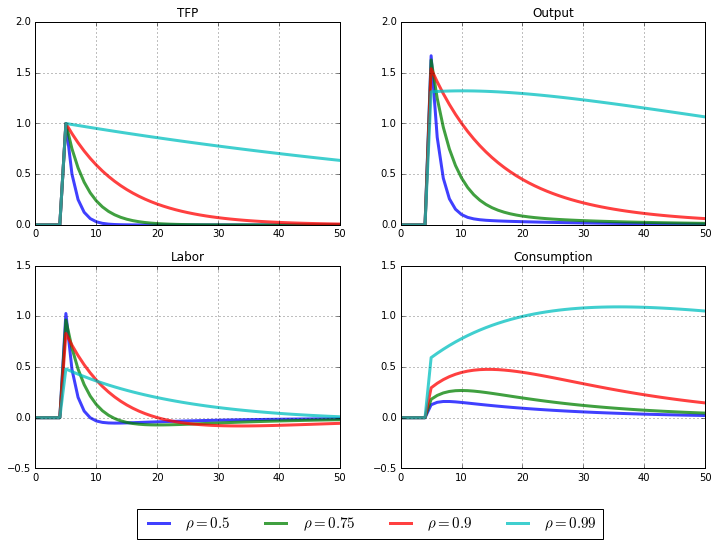

In [6]:
# Create a 12x8 figure
fig = plt.figure(figsize=(12,8))

# Create four axis variables: 'ax1', 'ax2', 'ax3', 'ax4'
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

# Create an axis equal to the size of the figure. PROVIDED
ax0 = fig.add_subplot(1,1,1)
# Turn off the axis so that the underlying axes are visible. PROVIDED
ax0.set_frame_on(False)
# Hide the x-axis. PROVIDED
ax0.get_xaxis().set_visible(False)
# Hide the y-axis. PROVIDED
ax0.get_yaxis().set_visible(False)

# Create variable called 'rho_values' that stores the desired values of rho
rho_values = [0.5,0.75,0.9,0.99]

# Iterate over the elements of rho_values
for rho in rho_values:
    
    # Update the value of rho in rbc_model.parameters
    rbc_model.parameters['rho'] = rho
    
    # Compute the steady state with initial guess equal to [1,4,1,1,1,0.5]
    rbc_model.compute_ss([1,4,1,1,1,0.5])
    
    # Approximate the model and solve
    rbc_model.approximate_and_solve()
    
    # Compute the impulse responses to a 0.01 unit shock to TFP
    rbc_model.impulse(T=51,t0=5,shocks=[0.01,0])
    
    # Add plots of TFP, output, labor, and consumption to ax1, ax2, ax3, and ax4
    ax1.plot(rbc_model.irs['e_a']['a']*100,lw=3,alpha=0.75)
    ax2.plot(rbc_model.irs['e_a']['y']*100,lw=3,alpha=0.75)
    ax3.plot(rbc_model.irs['e_a']['l']*100,lw=3,alpha=0.75)
    ax4.plot(rbc_model.irs['e_a']['c']*100,lw=3,alpha=0.75)
    
    # Plot the point 0,0 on ax0 with the same line properties used for the other plotted lines and provide a label
    ax0.plot(0,0,lw=3,alpha=0.75,label='$\\rho='+str(rho)+'$')
    
    
# Set axis titles to the axes
ax1.set_title('TFP')
ax2.set_title('Output')
ax3.set_title('Labor')
ax4.set_title('Consumption')

# Add grids to the axes
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

# Set ax1 y-axis limits to [0,2]
ax1.set_ylim([0,2])
# Set ax2 y-axis limits to [0,2]
ax2.set_ylim([0,2])
# Set ax3 y-axis limits to [-0.5,1.25]
ax3.set_ylim([-0.5,1.5])
# Set ax4 y-axis limits to [-0.5,1.5]
ax4.set_ylim([-0.5,1.5])

# Add legend below the figure. PROVIDED
legend = ax0.legend(loc='upper center',bbox_to_anchor=(0.5,-0.075), ncol=4,fontsize=15)

## Example: Stochastic Simulation

Compute a 401 period stochastic simulation of the model. Set $\rho=0.75$ to match US business cycle data. And set the seed for the simulation to 126.

In [7]:
# Set the value of rho in rbc_model.parameters to 0.75
rbc_model.parameters['rho'] = rho

# Compute the steady state with initial guess equal to [1,4,1,1,1,0.5]
rbc_model.compute_ss([1,4,1,1,1,0.5])

# Approximate the model and solve
rbc_model.approximate_and_solve()

In [8]:
# Compute the stochastic simulation using the .stoch_sim() method of rbc_model
rbc_model.stoch_sim(T=401,covMat=[[parameters['sigma_squared'],0],[0,0]],seed=126)

On a single axis, plot the simulated values for output, consumption, investment, and labor.

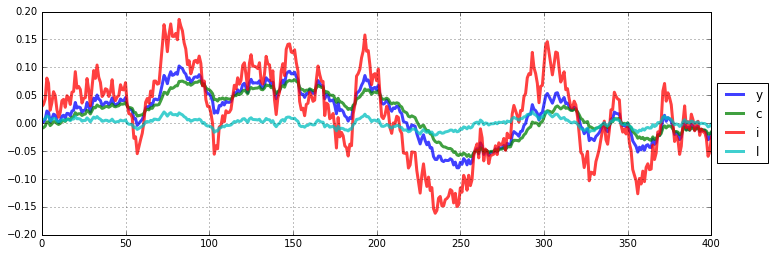

In [9]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,1,1)
rbc_model.simulated[['y','c','i','l']].plot(ax=ax,lw=3,alpha=0.75)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()

In [10]:
# Print the standard deviations (times 100) of output, consumption, investment, and labor in the simulated data
rbc_model.simulated[['y','c','i','l']].std()*100

y    4.369084
c    3.712526
i    7.532025
l    0.892732
dtype: float64

In [11]:
# Print the correlations of output, consumption, investment, and labor in the simulated data
rbc_model.simulated[['y','c','i','l']].corr()

,y,c,i,l
y,1.000000,0.958013,0.904906,0.606708
c,0.958013,1.000000,0.744878,0.353309
i,0.904906,0.744878,1.000000,0.887343
l,0.606708,0.353309,0.887343,1.000000
